In [1]:
# BATS (DG)s
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 12
ge = 175
x = Glider(35, np.arange(gs, ge + 1), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035')

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2015_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 450
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge + 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0]
dac_v = dg_data['Dac_v'][0][0][0]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]


In [2]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

In [3]:
# -- Background density profiles and seasonal variability
# Season Boundaries 
bd1 = 735750  # june1 (june1 = 735750) (may15 = 735733)
bd2 = 735856  # sept15

# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -64.09

# three seasons
# (June 1 - Sept 15)
d_summer_w = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_summer_e = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) > lon_lim))[0]
# (Winter 1 = Feb 2 - June 1) - (Winter 2 = Sept 15 - Nov 5)
d_winter_w1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_winter_e1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) > lon_lim))[0]
d_winter_w2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) < lon_lim))[0]
d_winter_e2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
                       & (np.nanmean(lon, axis=0) > lon_lim))[0]

bckgrds = [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
bckgrds_info = ['Summer West', 'Summer East','Winter1 West', 'Winter1 East','Fall West', 'Fall East']

# ABOVE SETS ORDER OF N2 PROFILES (different that order at the end)
# bckgrds_wins = np.array([bd1, bd2])  # summer boundaries
# bckgrds = [d_win1, d_sum, d_win2, d_eddy]  # KEY!! at the end, sets of profiles

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

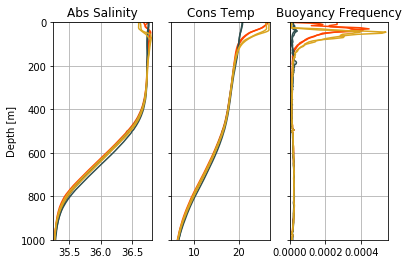

()

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = 'r', 'm', 'b', 'c', 'g', 'y'  # summer, summer, winter1, winter1, winter2, winter2
coli = '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35.25, 36.81])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([5, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.00055])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)
# ax3.grid()
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/bats_dg_t_s_n2.jpg", dpi=300)

In [5]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)        

In [6]:
print(dg_v_dive_no_0)
print(profile_tags_per[25][0:-1])

[  12.    12.5   13.    13.5   14.    27.    27.5   28.    28.5   29.    40.
   40.5   41.    48.    48.5   49.    49.5   50.    59.    59.5   60.
   60.5   61.    72.    72.5   73.    73.5   74.    88.    88.5   89.    97.
   97.5   98.   109.   109.5  110.   110.5  111.   119.   119.5  120.   128.
  128.5  129.   139.   139.5  140.   140.5  141.   151.   151.5  152.
  152.5  153.   160.   160.5  161.   161.5  162.   173.   173.5  174.    20.
   20.5   21.    32.    32.5   33.    33.5   34.    44.    44.5   45.    54.
   54.5   55.    55.5   56.    65.    65.5   66.    66.5   67.    79.
   79.5   80.    80.5   81.    81.5   82.    82.5   83.    83.5   84.
   84.5   85.    92.    92.5   93.    93.5   94.   101.   101.5  102.
  102.5  103.   114.   114.5  115.   115.5  116.   123.   123.5  124.
  124.5  125.   132.   132.5  133.   133.5  134.   134.5  135.   147.
  147.5  148.   156.   156.5  157.   166.   166.5  167.   167.5  168.    38.
   38.5   39.   145.   145.5  146.    17.    17.

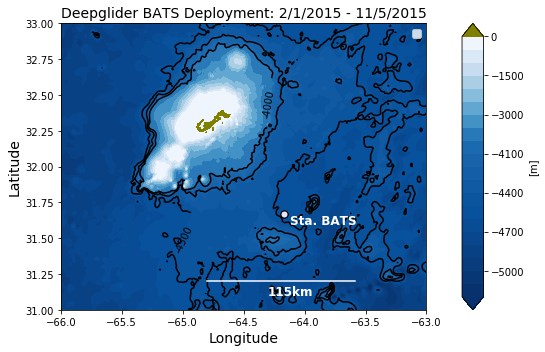

In [23]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable

bath = '/Users/jake/Desktop/bats/bats_bathymetry/GEBCO_2014_2D_-67.7_29.8_-59.9_34.8.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['lon'][:]
bath_lat = bath_fid.variables['lat'][:]
bath_z = bath_fid.variables['elevation'][:]
levels = [-5200, -5100, -5000, -4900, -4800, -4700, -4600,
          -4500, -4400, -4300, -4200, -4100, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0]
fig0, ax0 = plt.subplots()
cmap = plt.cm.get_cmap("Blues_r")
cmap.set_over('#808000')  # ('#E6E6E6')
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-4500, -4250, -4000], colors='k', zorder=0)
ml = [(-65, 31.5), (-64.4, 32.435)]
ax0.clabel(bcl, manual=ml, inline_spacing=-3, fmt='%1.0f', colors='k')

# ax0.scatter(lon, lat, s=0.3, color='#DAA520')
# ax0.scatter(dg_v_lon, dg_v_lat, s=3, color='#DAA520', edgecolor='#B8860B')
# ax0.plot(lon[:, -1], lat[:, -1], color='#DAA520',
#         label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)

ax0.plot([-64.8, -63.59], [31.2, 31.2], color='w', zorder=2)
ax0.text(-64.3, 31.1, '115km', color='w', fontsize=12, fontweight='bold')
ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=3)
ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=4)
ax0.text(-(64 + (10 / 60)) + .05, 31 + (40 / 60) - .07, 'Sta. BATS', color='w', fontsize=12, fontweight='bold')
w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.axis([-66, -63, 31, 33])
ax0.set_aspect(w)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig0.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=11)
ax0.set_title('Deepglider BATS Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=14)
plt.tight_layout()
fig0.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/bats_bathy.jpg", dpi=300)

(937,)
(601,)
(601, 937)
31.6625


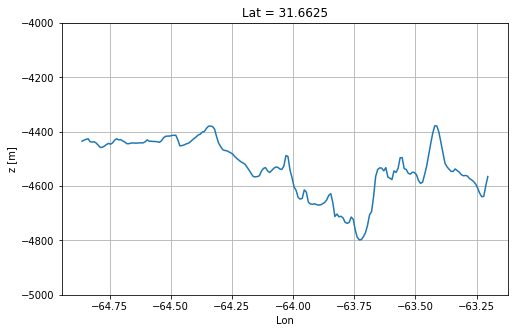

In [306]:
print(np.shape(bath_lon))
print(np.shape(bath_lat))
print(np.shape(bath_z))
lat_sel = 224
print(bath_lat[lat_sel])

lon_sel = bath_lon[340:540]
z_sel = bath_z[lat_sel, 340:540]
x_sel = 1852 * 60 * np.cos(np.deg2rad(31.00)) * (lon_sel - lon_sel[0])
# fitt = np.polyval(np.polyfit(x_sel, z_sel, 1), np.arange(0, 150000, 10000))
matplotlib.rcParams['figure.figsize'] = (8,5)
f, ax  = plt.subplots()
ax.plot(lon_sel, z_sel)
# ax.plot(np.arange(0, 150000, 10000), fitt)
ax.set_title('Lat = ' + str(bath_lat[lat_sel]))
ax.set_ylabel('z [m]')
ax.set_xlabel('Lon')
ax.set_ylim([-5000, -4000])
plot_pro(ax)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/bats_bathy_cross.jpg", dpi=300)

In [7]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    this_lon = dg_v_lon[i]
    # match profile with appropriate background (in time and space)
    # t_over = np.where(bckgrds_wins > this_time)[0]
    # bckgrds_wins = np.array([735750, 735857])  # summer boundaries

    # first sort by lon
    # [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
    if this_lon < lon_lim:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 0  # summer west
        elif this_time < bd1:
            t_over = 2  # winter west 1
        else:
            t_over = 4  # winter west 2
    else:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 1  # summer east
        elif this_time < bd1:
            t_over = 3  # winter east 1
        else:
            t_over = 5  # winter west 2    

#     # [d_summer_w, d_summer_e, d_winter_w, d_winter_e]
#     if this_lon < lon_lim:
#         if (this_time > bd1) & (this_time < bd2):  # summer
#             t_over = 0  # summer west
#         else:
#             t_over = 2  # winter west
#     else:
#         if (this_time > bd1) & (this_time < bd2):  # summer
#             t_over = 1  # summer east
#         else:
#             t_over = 3  # winter east 

    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
            # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [8]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_time = np.nanmean(d_time[:, i])
    # t_over = np.where(bckgrds_wins > this_time)[0]

    # [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
    if this_lon < lon_lim:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 0  # summer west
        elif this_time < bd1:
            t_over = 2  # winter west 1
        else:
            t_over = 4  # winter west 2
    else:
        if (this_time > bd1) & (this_time < bd2):  # summer
            t_over = 1  # summer east
        elif this_time < bd1:
            t_over = 3  # winter east 1
        else:
            t_over = 5  # winter west 2

#     # [d_summer_w, d_summer_e, d_winter_w, d_winter_e]
#     if this_lon < lon_lim:
#         if (this_time > bd1) & (this_time < bd2):  # summer
#             t_over = 0  # summer west
#         else:
#             t_over = 2  # winter west
#     else:
#         if (this_time > bd1) & (this_time < bd2):  # summer
#             t_over = 1  # summer east
#         else:
#             t_over = 3  # winter east             

    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/Documents/geostrophic_turbulence/mode_decompositions.py:248: RuntimeWarning: overflow encountered in ushort_scalars
  eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in greater


In [9]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[10:-20, i], -1 * grid[10:-20])
    # print(np.nanmax(np.abs(dv_dz)))
    if np.nanmax(np.abs(dv_dz)) < 0.0025:  # 0.0225
        good_v[i] = True
good_v[np.abs(dg_v_0[5,:]) > 1] = False
        
avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice


In [204]:
# dives to choose from in comparing etas below 
np.sum(good_v)

131

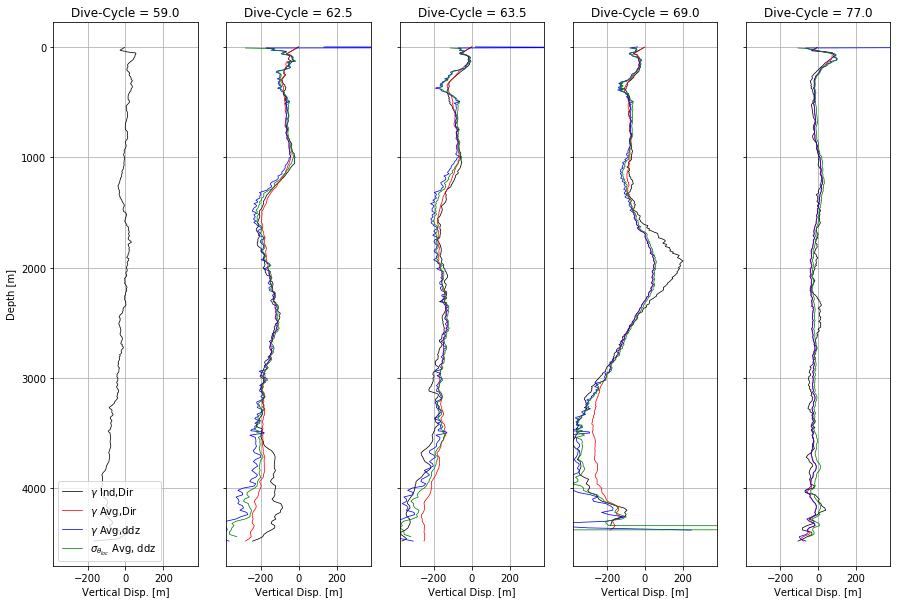

()

In [10]:
# plot etas calculated above
# these_profiles = np.array([27.5,   28. ,   28.5,   40.5,   48.5])
# these_profiles = np.array([52, 53, 54, 55, 56])
# these_profiles = np.array([75.5, 76, 76.5, 77, 77.5])
# these_profiles = np.array([ 81.5,   82. ,   82.5,   83. ,   83.5])
# these_profiles = np.array([132.5,  133. ,  133.5,  134. ,  134.5,])
# these_profiles = np.array([50, 75, 100, 125])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([60, 85, 110, 135])  # dive numbers of profiles to compare (individual dives)
these_profiles = np.array([59, 62.5, 63.5, 69, 77])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = dg_v_dive_no_0 == these_profiles[i]
    ax[i].plot(eta_per_prof_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\gamma$ Ind,Dir')  # individual profiles direct search, gamma
    ax[i].plot(eta_alt_3[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\gamma$ Avg,Dir')  # avg direct search, gamma
    ax[i].plot(-1 * eta_alt_0[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\gamma$ Avg,ddz')  # avg divide by ddz, gamma
    ax[i].plot(-1 * eta_alt_2[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\sigma_{\theta_{loc}}$ Avg, ddz')  # avg divide by ddz, pot den, local pref
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle = ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])
# ax[4].grid()
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/eddy_etas.jpg", dpi=300)

In [11]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# by season
# [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2] ordering set above
# N2 order = 
G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 2:4], axis=1), grid, omega, mmax)  # winter1
G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 0:2], axis=1), grid, omega, mmax)  # summer
G_2, Gz_2, c_2, epsilon_2 = vertical_modes(np.nanmean(N2[:, 4:], axis=1), grid, omega, mmax)  # winter2
Gs = [G_0, G_1, G_2]
Gzs = [Gz_0, Gz_1, Gz_2]
cs = [c_0, c_1, c_2]
epsilons = [epsilon_0, epsilon_1, epsilon_2]
# test using average over entire year
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(np.nanmean(N2, axis=1), grid, omega, mmax)  # N2

# --- compute alternate vertical modes
bc_bot = 2  # 1 = flat, 2 = rough
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, dg_avg_N2)
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


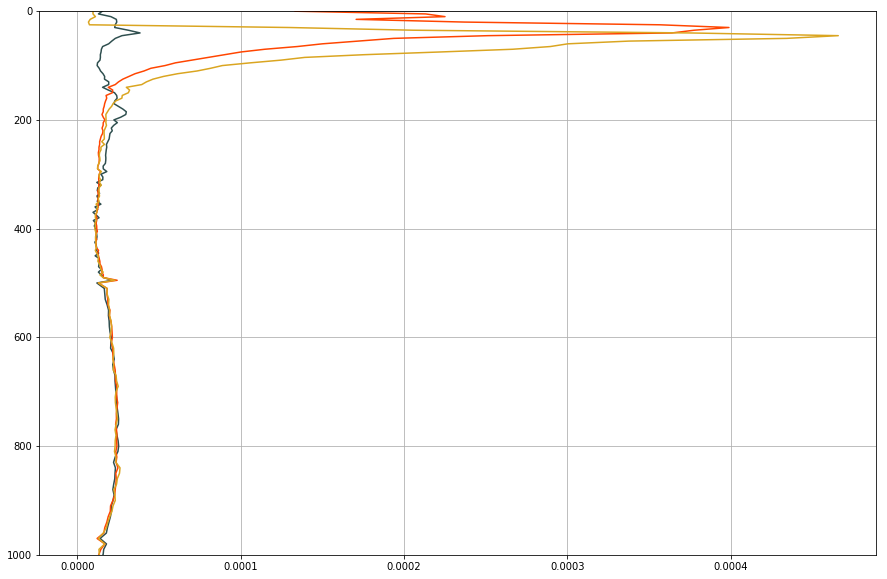

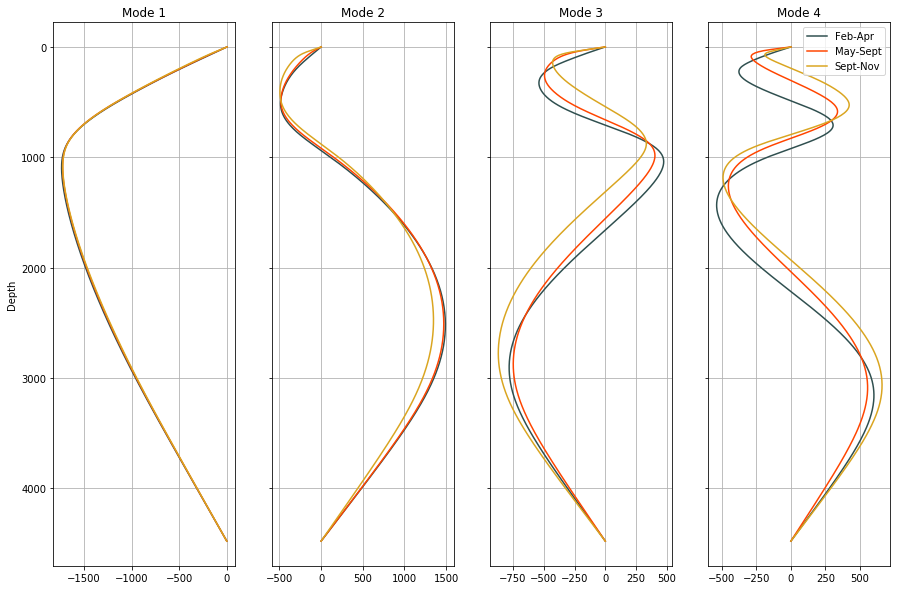

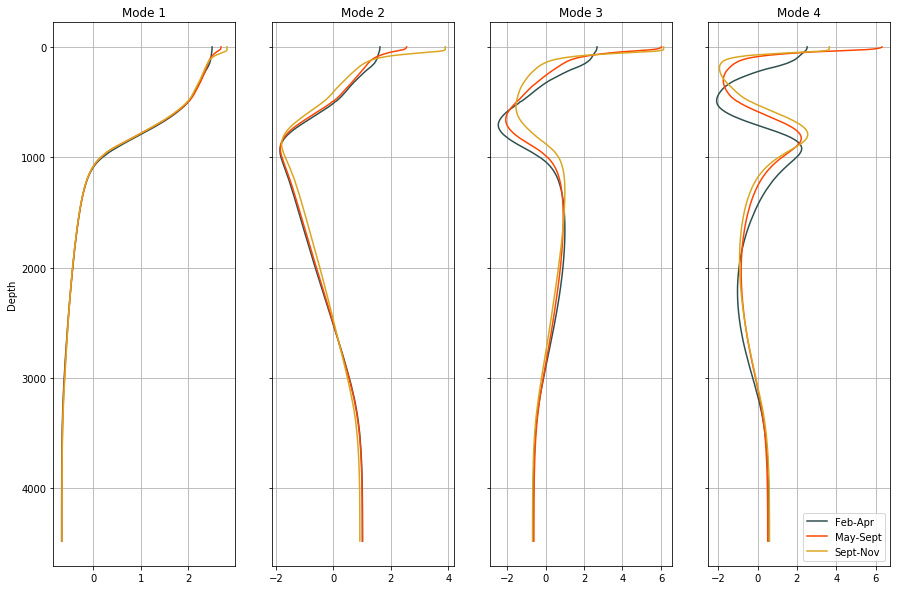

()

In [12]:
# PLOT --- test season differences in modes
f, ax = plt.subplots()
ax.plot(np.nanmean(N2[:, 2:4], axis=1), grid, color=cols[0])
ax.plot(np.nanmean(N2[:, 0:2], axis=1), grid, color=cols[1])
ax.plot(np.nanmean(N2[:, 4:], axis=1), grid, color=cols[2])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
plot_pro(ax)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gzs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gzs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gzs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gzs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)

From Zhao et al. 2016 (appendix A), the ratio of surface displacement to maximum interior displacement. He gave me a map at BATS of the surface displacement from the M2 and S2 internal tides (order 1 - 5mm). For every 1mm surface displacement we expect 750mm maximum interior displacement (for mode 1). If I estimate the interior displacement using his estimate of surface amplitude and my mode shapes (where there is a free surface, skewing his estimate) I get an interior displacement of less than 10 m for both the M2 and S2 tides.

In [11]:
# testing of tides from Dr. Zhao
normalizer = (1/np.nanmax(grid))*np.trapz(Gzs[0][:, 1]**2, grid)
(0.005) / ((1/g) * np.trapz(Gzs[0][:, 1] * np.nanmean(N2[:, 2:4], axis=1), grid))

1.5983952540299899

In [22]:
# Kjellsson and Zanna paper 2017 on the importance of resolving the deformation radius in modes 
Lr1 = (1/3.14159) * np.trapz(np.sqrt(N2[:, 0])/f_ref, grid)
print(Lr1/1000)
print((cs[0][1:4]/f_ref)/1000)


37.1479414496
[ 39.33132111  16.41174672  11.82046183]


In [37]:
# from the zanna paper Lr = radius of deformation (in figure 5, plot wavenumber )
1. / ((1.7 * 10**(-4))/(2*3.14))

36941.17647058823

In [13]:
# ----- SOME VELOCITY PROFILES ARE TOO NOISY AND DEEMED UNTRUSTWORTHY -------------------------------------------------
# really just copying at this point 
Avg_sig = avg_sig.copy()
Time2 = dg_mw_time.copy()
V2 = dg_v.copy()
Eta2 = eta_alt.copy()   # eta_alt already defined above as one of the three methods
Eta2_c = eta_alt.copy()
Info2 = dg_v_dive_no.copy()
prof_lon2 = dg_v_lon.copy()
prof_lat2 = dg_v_lat.copy()
# for this selection find appropriate background structure
# these are the indices that satisfy the different seasons
d2_summer = np.where((Time2 > bd1))[0]  # & (Time2 < bd2)
d2_winter1 = np.where((Time2 < bd1) & ((Info2 < 60) | (Info2 > 71)))[0]
# d2_winter2 = np.where(Time2 > bd2)[0]
bckgrds2 = [d2_summer, d2_winter1]  # , d2_winter2

In [33]:
np.shape(dg_v_0)

(450, 261)

In [14]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(Eta2)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    if len(np.intersect1d(d2_winter1, i)) | ((Info2[i] > 60) & (Info2[i] < 71)):
        G = G_tot  # G_0
        Gz = Gz_tot  # Gz_0
        c = c_tot  # c_0
    elif len(np.intersect1d(d2_summer, i)):
        G = G_tot  # G_1
        Gz = Gz_tot  # Gz_1
        c = c_tot  # c_1
    else:
        G = G_tot  # G_2
        Gz = Gz_tot  # Gz_2
        c = c_tot  # c_2

    # fit to velocity profiles
    this_V = V2[:, i].copy()
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = Eta2[:, i].copy()
    # obtain matrix of NEta
    Neta[:, i] = N_all * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = Eta2[:, i].copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = N_all * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

In [15]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(Time2)
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]
Time_ordered = Time2[mw_time_ordered_i]
HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
Info3 = Info2[mw_time_ordered_i]
V_ordered = V2[:, mw_time_ordered_i]
Vm_ordered = V_m[:, mw_time_ordered_i]
Eta_ordered = Eta2[:, mw_time_ordered_i]
Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [223]:
Time2.shape

(133,)

In [16]:
# --- EOF of velocity profiles (for whole mission)
check1 = 7      # upper index to include in eof computation
check2 = -10     # lower index to include in eof computation
grid_check = grid[check1:check2]
V4 = V2[check1:check2, :].copy()

checkk = np.zeros(np.shape(V4)[1])
for j in range(np.shape(V4)[1]):
    checkk[j] = np.sum(np.isnan(V4[:, j]))
Uzq = V4[:, checkk < 1].copy()

nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)

t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)

# --- EOF of displacement profiles 
# check1 = 7      # upper index to include in eof computation
# check2 = -14     # lower index to include in eof computation
# grid_check = grid[check1:check2]
# xi_zq = eta_alt[check1:check2, 55:85].copy()
# nq = np.size(xi_zq[0, :])
# avg_xi_zq = np.nanmean(np.transpose(xi_zq), axis=0)
# xi_zqa = xi_zq - np.transpose(np.tile(avg_xi_zq, [nq, 1]))
# cov_xi_zqa = (1 / nq) * np.matrix(xi_zqa) * np.matrix(np.transpose(xi_zqa))
# D_xi_zqa, V_xi_zqa = np.linalg.eig(cov_xi_zqa)

# t1_xi = np.real(D_xi_zqa[0:10])
# PEV_xi = t1_xi / np.sum(t1_xi)

In [166]:
checkk

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


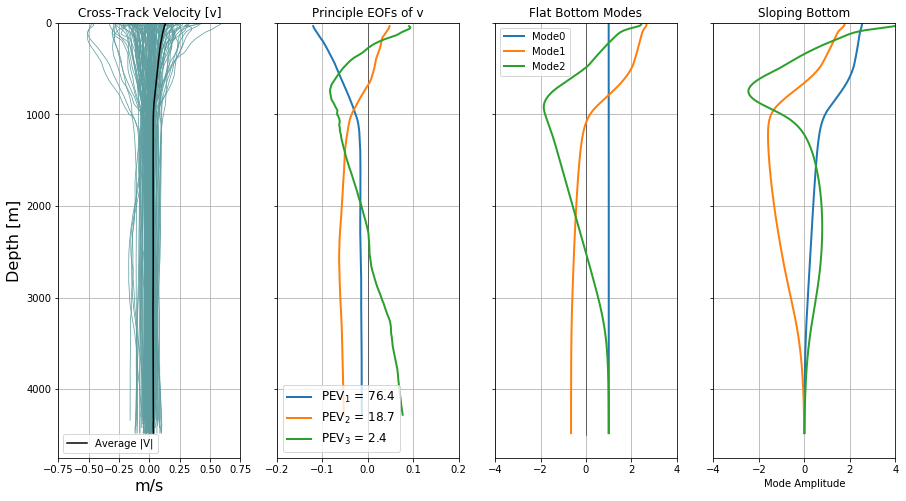

In [17]:
# --- plot velocity EOFs 
matplotlib.rcParams['figure.figsize'] = (15,8)
f, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(np.shape(V2)[1]):
    ax.plot(V2[:, i], grid, color='#5F9EA0', linewidth=0.75)
ax.plot(np.nanmean(np.abs(V2), axis=1), grid, color='k', label='Average |V|')
ax.set_xlim([-.75, .75])
ax.set_ylim([0, 4750])
ax.set_title('Cross-Track Velocity [v]', fontsize=12)
ax.set_xlabel('m/s', fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)

ax2.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
ax3.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
colorm = 'r', 'b', 'g'
for i in range(3):
    ax2.plot(V_Uzqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)),
                linewidth=2)
#     ax3.plot(V_xi_zqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV_xi[i], 3)),
#                 linewidth=2)
    ax3.plot(Gz[:, i], grid, label='Mode' + str(i), linewidth=2)
    ax4.plot(F[:, i], grid, label='Mode' + str(i), linewidth=2)

    # if i < 1:
    #     ax4.plot(F_int[:, i] + np.nanmax(np.abs(F_int[:, i])), grid)
    # else:
    #     ax4.plot(F_int[:, i], grid)
    # ax4.plot(G[:, i], grid, c='k', linestyle='--', linewidth=0.5)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12)
ax2.set_xlim([-.2, .2])
ax2.set_title('Principle EOFs of v', fontsize=12)
# ax2.set_xlabel('m/s', fontsize=16)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.set_xlim([-4, 4])
ax3.set_title('Flat Bottom Modes', fontsize=12)
# ax3.set_xlabel('[m]', fontsize=10)
ax4.set_title('Sloping Bottom', fontsize=12)
ax4.set_xlabel('Mode Amplitude', fontsize=10)
ax4.set_xlim([-4, 4])
ax.grid()
ax2.grid()
ax3.grid()
ax.invert_yaxis()
plot_pro(ax4)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_v_eof_tot.jpg", dpi=300)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.046690
         Iterations: 25
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 0.067731
         Iterations: 9
         Function evaluations: 18
[ 0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.013851
         Iterations: 21
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 0.036487
         Iterations: 7
         Function evaluations: 14
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.024539
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 0.044572
         Iterations: 15
         Function evaluations: 30
[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

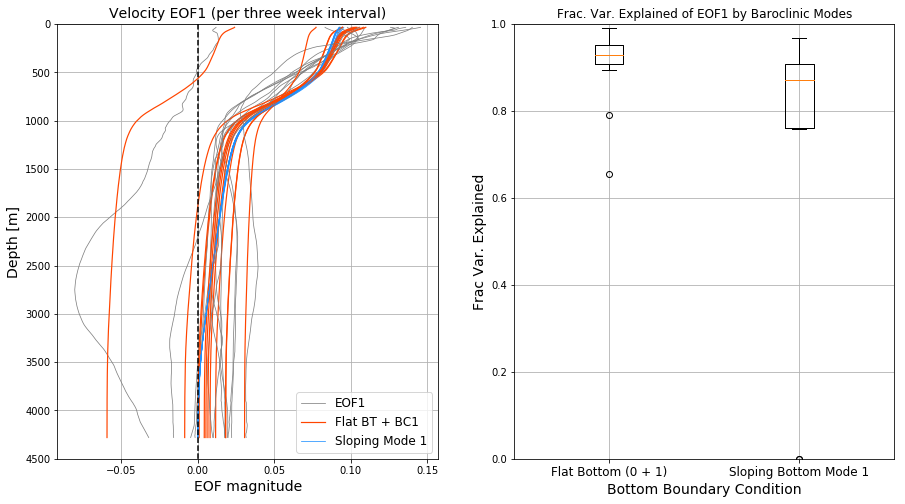

In [281]:
# --- EOF of velocity profiles (in two week intervals) ---
def functi_1(p, xe, xb):
    #  This is the target function that needs to be minimized
    fsq = (xe - p*xb)**2
    return fsq.sum()

def functi_2(p, xe, xb, xs):
    #  This is the target function that needs to be minimized
    fsq = (xe - (p[0] * xb + p[1] * xs)) ** 2
    # fsq = (xe - p*xb)**2
    return fsq.sum()

# loop over every two weeks (to obtain statistics)
T_week = np.arange(Time2.min(), Time2.max(), 21)
check1 = 7      # upper index to include in eof computation
check2 = -10    # lower index to include in eof computation
grid_check = grid[check1:check2]
Uzq = V2[check1:check2, :].copy()

PEV_per = np.nan * np.ones((len(T_week) - 1, 10))
fvu1_per = np.nan * np.ones(len(T_week) - 1)
fvu2_per = np.nan * np.ones(len(T_week) - 1)
bc1 = Gz[check1:check2, 0]  # flat bottom (modes 0)
bc11 = + Gz[check1:check2, 1]  # flat bottom (modes 1)
bc2 = F[check1:check2, 0]  # sloping bottom  (modes 1 + 2 ... there is no barotropic mode)
f, (ax, ax1) = plt.subplots(1, 2)
AGz_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
AF_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
for i in range(len(T_week) - 1):
    if i >= (len(T_week) - 2):
        V4 = Uzq[:, (Time_ordered > T_week[i])].copy()
    else:
        V4 = Uzq[:, (Time_ordered > T_week[i]) & (Time_ordered < T_week[i + 1])].copy()
    checkk = np.zeros(np.shape(V4)[1])
    for j in range(np.shape(V4)[1]):
        checkk[j] = np.sum(np.isnan(V4[:, j]))
    V4 = V4[:, checkk < 1]    
    
    print(checkk)
    nq = np.size(V4[0, :])
    avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
    Uzqa = V4 - np.transpose(np.tile(avg_Uzq, [nq, 1]))
    cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
    D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
    t1 = np.real(D_Uzqa[0:10])
    # percent explained variance by each eof
    PEV_per[i, :] = (t1 / np.sum(t1))
    # percent variance explained of each eof by baroclinic modes with either bottom boundary condition
    eof1 = np.array(np.real(V_Uzqa[:, 0]))
    # -- minimize mode shapes onto eof shape
    p = np.array([0.8 * eof1.min() / np.max(np.abs(F[:, 0])), 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))])
    p2 = 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))
    ins1 = np.transpose(np.concatenate([eof1, bc1[:, np.newaxis], bc11[:, np.newaxis]], axis=1))
    ins2 = np.transpose(np.concatenate([eof1, bc2[:, np.newaxis]], axis=1))
    min_p1 = fmin(functi_2, p, args=(tuple(ins1)))
    min_p2 = fmin(functi_1, p2, args=(tuple(ins2)))
    fvu1_per[i] = 1 - (np.sum((eof1[:, 0] - (bc1 * min_p1[0] + bc11 * min_p1[1])) ** 2) /
                    np.sum((eof1 - np.mean(eof1)) ** 2))
    fvu2_per[i] = 1 - (np.sum((eof1[:, 0] - bc2 * min_p2) ** 2) / np.sum((eof1 - np.mean(eof1)) ** 2))

    if np.nanmean(bc1[0:6] * min_p1[0] + bc11[0:6] * min_p1[1]) < 0:  # np.nanmean(eof1[0:20] < 0):
        if fvu1_per[i] > 0:
            ax.plot(-1 * eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot(-1 * (bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(-1 * bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
    else:
        if fvu1_per[i] > 0:
            ax.plot(eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot((bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
ax.plot([0, 0], [0, 4500], color='k', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1], handles[2]], [labels[0], labels[1], labels[2]], fontsize=12)
ax.set_title('Velocity EOF1 (per three week interval)', fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('EOF magnitude', fontsize=14)
ax.set_ylim([0, 4500])
ax.invert_yaxis()

fvu1_per[fvu1_per < 0] = 0.
fvu2_per[fvu2_per < 0] = 0.

# data1 = np.array([np.nanstd(PEV_per[:, 0]), np.nanmean(PEV_per[:, 0]), np.nanmin(PEV_per[:, 0]),
#                     np.nanmax(PEV_per[:, 0])])
# data2 = np.array([np.nanstd(PEV_per[:, 1]), np.nanmean(PEV_per[:, 1]), np.nanmin(PEV_per[:, 1]),
#                     np.nanmax(PEV_per[:, 1])])
# data3 = np.array([np.nanstd(fvu1_per), np.nanmean(fvu1_per), np.nanmin(fvu1_per), np.nanmax(fvu1_per)])
# data4 = np.array([np.nanstd(fvu2_per), np.nanmean(fvu2_per), np.nanmin(fvu2_per), np.nanmax(fvu2_per)])

# ax1.boxplot([data1, data2])
# np.concatenate((fvu1_per[:, None], fvu2_per[:, None]), axis=1)
ax1.boxplot([fvu1_per[~np.isnan(fvu1_per)], fvu2_per[~np.isnan(fvu2_per)]])  # fvu1_per[:, None]
ax1.set_ylim([0, 1])
ax1.set_title('Frac. Var. Explained of EOF1 by Baroclinic Modes')
ax1.set_xlabel('Bottom Boundary Condition', fontsize=14)
ax1.set_ylabel('Frac Var. Explained', fontsize=14)
ax1.set_xticklabels(['Flat Bottom (0 + 1)', 'Sloping Bottom Mode 1'], fontsize=12)
# ax2.set_title('Bottom Boundary Condition')
# ax2.set_ylabel('Frac Var. Explained by Mode Shapes')
# ax2.set_ylim([0, 1])
ax.grid()
plot_pro(ax1)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_v_eofs.jpg", dpi=300)

In [283]:
fvu1_per

array([ 0.92213567,  0.96656139,  0.94868162,  0.93746826,  0.99155695,
        0.91723186,  0.96081029,  0.93641837,  0.91375758,  0.65510765,
        0.78980104,  0.89395198])

The figure above addresses the de La Lama conclusion and compares which structure captures more of the variance of the horizontal velocity profiles (structure 1 = BT + BC1 (flat bottom), structure 2 = BC1 (sloping bottom) 

In [18]:
# --- Isolate eddy dives ---
# 2015 - dives 62, 63 ,64
# ed_prof_in = np.where(((x.dives) >= 62) & ((x.dives) <= 66))[0]
ed_in = np.where((Info3 >= 62) & (Info3 <= 70))[0]
ed_time_s = datetime.date.fromordinal(np.int(Time_ordered[ed_in[0]]))
ed_time_e = datetime.date.fromordinal(np.int(Time_ordered[ed_in[-1] + 1]))
# --- time series
mission_start = datetime.date.fromordinal(np.int(Time2.min()))
mission_end = datetime.date.fromordinal(np.int(Time2.max()))

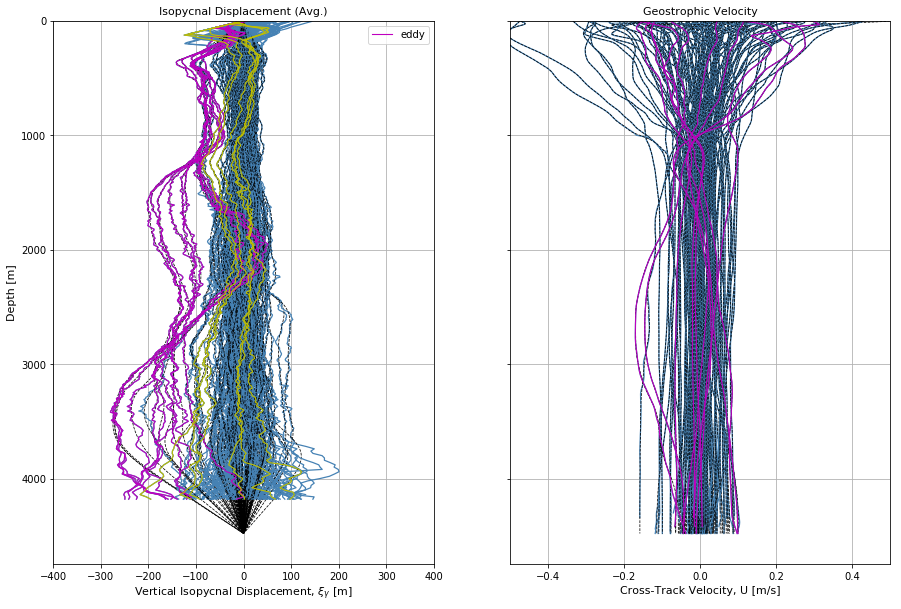

()

In [19]:
# plot eta 
plt.rcParams['figure.figsize'] = 15, 10
f_eta, (ax1, ax0) = plt.subplots(1, 2, sharey=True)
pzmax = -15
for j in range(num_profs):
    ax1.plot(Eta2[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
    ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
    if good_ke_prof[j] > 0:
        ax0.plot(V2[:, j], grid, color='#4682B4', linewidth=1.25)
        ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)

for k in range(len(ed_in)):
    ax1.plot(Eta_ordered[0:pzmax, ed_in[k]], grid[0:pzmax], color='m', linewidth=1.1, label='eddy')
    ax0.plot(V_ordered[:, ed_in[k]], grid, color='m', linewidth=1.1)
# before eddy
pre_ed = np.where((Info2 >= 55) & (Info2 <= 62))[0]
for k in range(len(pre_ed)):
    ax1.plot(Eta2[0:pzmax, pre_ed[k]], grid[0:pzmax], color='y', linewidth=1.1, label='eddy')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handles[0]], [labels[0]], fontsize=10)        
# ax0.text(150, 4500, str(num_profs) + ' Profiles')
ax1.set_xlim([-400, 400]) 
ax1.set_ylim([0, 4750])
ax1.invert_yaxis()
ax1.grid()
ax0.set_xlim([-.5, .5])
ax0.set_title("Geostrophic Velocity", fontsize=11)  # (" + str(num_profs) + 'profiles)' )
ax0.set_xlabel('Cross-Track Velocity, U [m/s]', fontsize=11)
ax1.set_xlabel(r'Vertical Isopycnal Displacement, $\xi_{\gamma}$ [m]', fontsize=11)
ax1.set_title(r'Isopycnal Displacement (Avg.)', fontsize=11)
ax1.set_ylabel('Depth [m]', fontsize=11)
plot_pro(ax0)    
# f_eta.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_eta_v.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


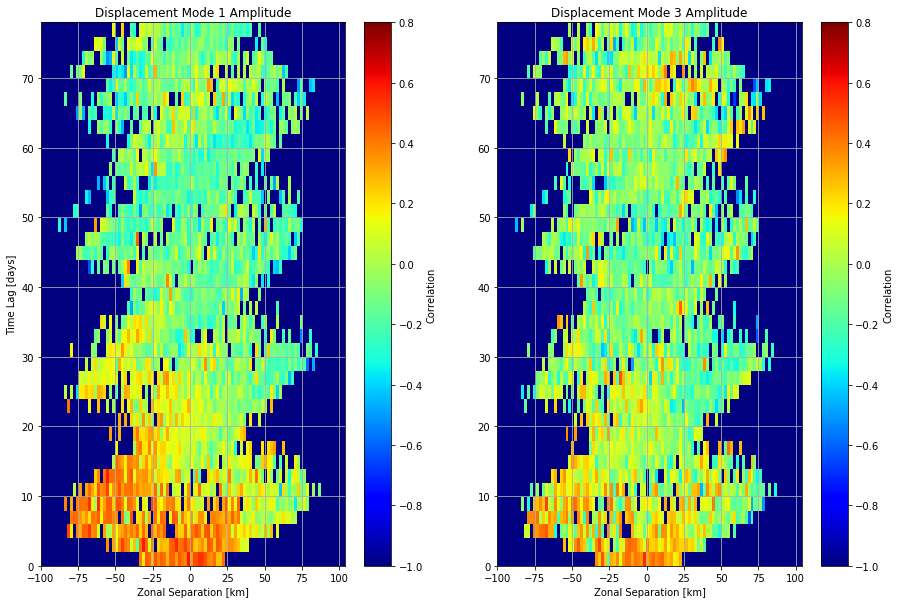

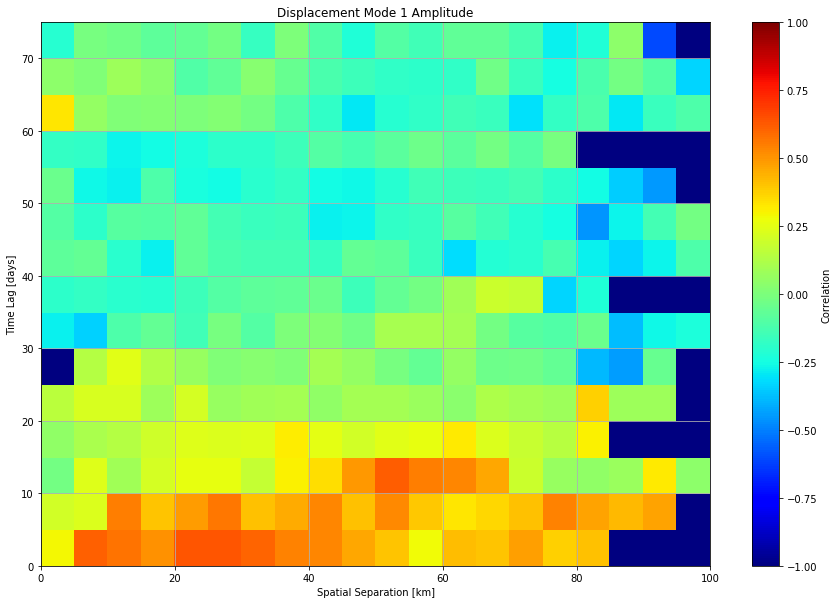

()

In [209]:
# Mode Amplitude Correlations 
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon)
y = 1852 * 60 * (prof_lat_i - ref_lat)
x_tile = np.tile(x, (len(x), 1))
y_tile = np.tile(y, (len(y), 1))
time_tile = np.tile(time_rec_bin, (len(time_rec_bin), 1))
dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
time_lag = np.abs(time_tile - time_tile.T)

# redo with only zonal separation
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon) / 1000
y = 1852 * 60 * (prof_lat_i - ref_lat) / 1000
t = time_rec_bin.copy()
AG_i = AG_all[1, :]
AG_ii = AG_all[3, :]

# distances apart
# dist_x = np.nan * np.zeros((len(x), len(x)))
# time_l = np.nan * np.zeros((len(x), len(x)))
for i in range(len(x) - 1):
    if i < 1:
        dist_x = x[i+1:] - x[i]
        dist_y = y[i+1:] - y[i]
        dist_t = np.sqrt(dist_x**2 + dist_y**2)
        time_l = np.abs(time_rec_bin[i] - t[i+1:])
        AG_count = np.array((AG_i[i] * np.ones(len(x[i+1:])), AG_i[i+1:]))
        AG_count2 = np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))
    else:
        dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
        dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
        dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i + 1:] - y[i])**2)))
        time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
        AG_count = np.concatenate((AG_count, np.array((AG_i[i] * np.ones(len(x[i + 1:])), AG_i[i + 1:]))), axis=1)
        AG_count2 = np.concatenate((AG_count2, 
                                    np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))), axis=1)
        
# define each box as all points that fall within a time and space lag
dist_win = np.arange(-100, 105, 2)
dist_t_win = np.arange(0, 105, 5)
t_win = np.arange(0, 80, 2)
t_t_win = np.arange(0, 80, 5)
corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))
for dd in range(len(dist_win) - 1):
    for tt in range(len(t_win) - 1):
        in_box = np.where((dist_x > dist_win[dd]) & (dist_x < dist_win[dd + 1]) & 
                          (time_l > t_win[tt]) & (time_l < t_win[tt + 1]))[0]
        if len(in_box) > 4:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(len(inski))
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z[tt, dd] = (1 / (n * variance)) * np.nansum(covi)

            inski_with = AG_count2[:, in_box]
            inski = np.unique(AG_count2[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z2[tt, dd] = (1 / (n * variance)) * np.nansum(covi)   
            
for dd in range(len(dist_t_win) - 1):
    for tt in range(len(t_t_win) - 1):
        in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                            (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
        if len(in_box) > 5:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_all[tt, dd] = (1 / (n * variance)) * np.nansum(covi)    
            
f, (ax1, ax2) = plt.subplots(1, 2)
pa = ax1.pcolor(dist_win, t_win, corr_i_z, vmin=-1, vmax=.8, cmap='jet')
pa2 = ax2.pcolor(dist_win, t_win, corr_i_z2, vmin=-1, vmax=.8, cmap='jet')
ax1.set_xlabel('Zonal Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax2.set_xlabel('Zonal Separation [km]')
ax1.set_title('Displacement Mode 1 Amplitude')
ax2.set_title('Displacement Mode 3 Amplitude')
f.colorbar(pa, ax=ax1, label='Correlation')
f.colorbar(pa2, ax=ax2, label='Correlation')
ax1.grid()
plot_pro(ax2)

f, ax1 = plt.subplots()
pa = ax1.pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap='jet')
ax1.set_xlabel('Spatial Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax1.set_title('Displacement Mode 1 Amplitude')
plt.colorbar(pa, label='Correlation')
plot_pro(ax1)            

In [20]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_0 = HKE_per_mass.copy()
PE_per_mass_0 = PE_per_mass.copy()
# HKE_per_mass = HKE_per_mass[:, np.where(good_ke_prof > 0)[0]]
# PE_per_mass = PE_per_mass[:, np.where(good_ke_prof > 0)[0]]
used_profiles = dg_v_dive_no[good_ke_prof > 0]
calmer = np.where((Info2 < 60) | (Info2 >= 71) & (good_ke_prof > 0))[0]  # excl. labby
# calmer = np.arange(0, np.int(np.sum(good_ke_prof)))
avg_PE = np.nanmean(PE_per_mass[:, calmer], 1)
avg_KE = np.nanmean(HKE_per_mass[:, calmer], 1)
# --- eddy kinetic and potential energy
PE_ed = np.nanmean(PE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)
KE_ed = np.nanmean(HKE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)

# --- ENERGY parameters ---
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
k_h = 1e3 * (f_ref / c[1:]) * np.sqrt(avg_KE[1:] / avg_PE[1:])
PE_SD, PE_GM, GMPE, GMKE = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(N2_all)), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(theta_avg, axis=1) +
                0.002377 * np.nanmean(theta_avg, axis=1) * np.nanmean(theta_avg, axis=1))
nu = mu / gsw.rho(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p)
avg_nu = np.nanmean(nu)


# --- most and least energetic profiles
KE_i = HKE_per_mass[:, calmer]
PE_i = PE_per_mass[:, calmer]
KE_it = np.nan * np.ones(KE_i.shape[1])
PE_it = np.nan * np.ones(KE_i.shape[1])
for i in range(KE_i.shape[1]):
    KE_it[i] = np.trapz(KE_i[1:, i] + PE_i[1:, i], 1000 * f_ref / c[1:])
    PE_it[i] = np.trapz(PE_i[1:, i], 1000 * f_ref / c[1:])
KE_i_max = np.where(KE_it == np.nanmax(KE_it))[0]
KE_i_min = np.where(KE_it == np.nanmin(KE_it))[0]
PE_i_max = np.where(PE_it == np.nanmax(PE_it))[0]
PE_i_min = np.where(PE_it == np.nanmin(PE_it))[0]
k_h_max = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_max]) / np.squeeze(PE_i[1:, KE_i_max]))
k_h_min = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_min]) / np.squeeze(PE_i[1:, KE_i_min]))

In [21]:
# --- LOAD in Comparison DATA ---
# --- load in Station BATs PE Comparison ---
pkl_file = open('/Users/jake/Desktop/bats/station_bats_pe_jan30.pkl', 'rb')  # update jan 2019
SB = pickle.load(pkl_file)
pkl_file.close()
sta_bats_pe = SB['PE_by_season']
sta_bats_c = SB['c']
sta_bats_depth = SB['depth']
sta_bats_f = np.pi * np.sin(np.deg2rad(31.6)) / (12 * 1800)
sta_bats_dk = sta_bats_f / sta_bats_c[1]
sta_bats_pe_total = np.nanmean(np.concatenate((np.nanmean(sta_bats_pe[0], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[1], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[2], axis=1)[:, None]), axis=1), axis=1)
sta_bats_n2_1 = SB['N2_per_season'][:, 1]
PE_SD_bats, PE_GM_bats, GMPE_bats, GMKE_bats = PE_Tide_GM(rho0, sta_bats_depth,
                                                          len(sta_bats_pe_total), sta_bats_n2_1[:, None], sta_bats_f)

# seasonal and variable spread at bats station for each mode
sta_max = np.nan * np.ones(len(sc_x))
sta_min = np.nan * np.ones(len(sc_x))
dg_per_max = np.nan * np.ones(len(sc_x))
dg_per_min = np.nan * np.ones(len(sc_x))
for i in range(1, mmax+1):
    test1 = np.nanmean(sta_bats_pe[0][i, :])
    test2 = np.nanmean(sta_bats_pe[1][i, :])
    test3 = np.nanmean(sta_bats_pe[2][i, :])
    # test4 = np.nanmean(sta_bats_pe[3][i, :])
    sta_max[i - 1] = np.max([test1, test2, test3])
    sta_min[i - 1] = np.min([test1, test2, test3])
    dg_per_max[i - 1] = np.nanmax(PE_per_mass_all[i, :])
    dg_per_min[i - 1] = np.nanmin(PE_per_mass_all[i, :])

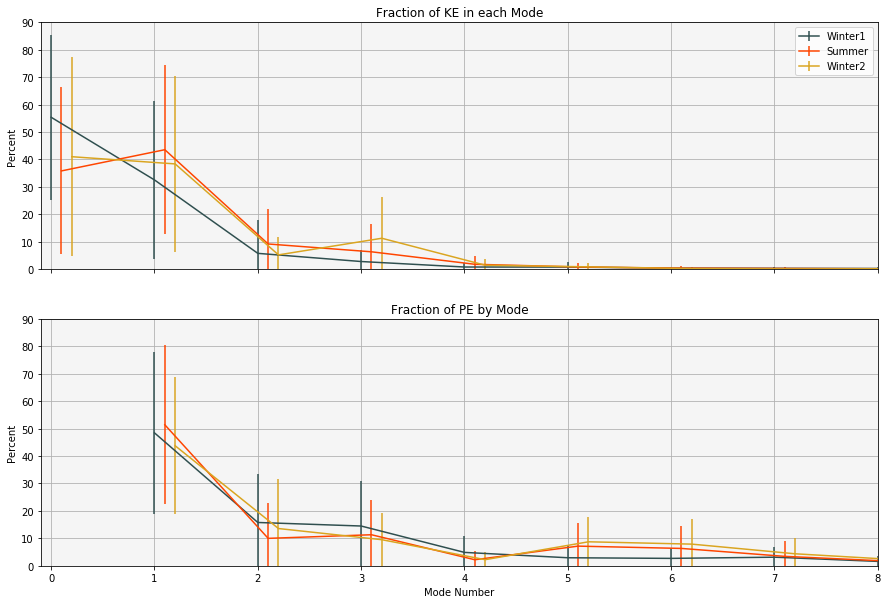

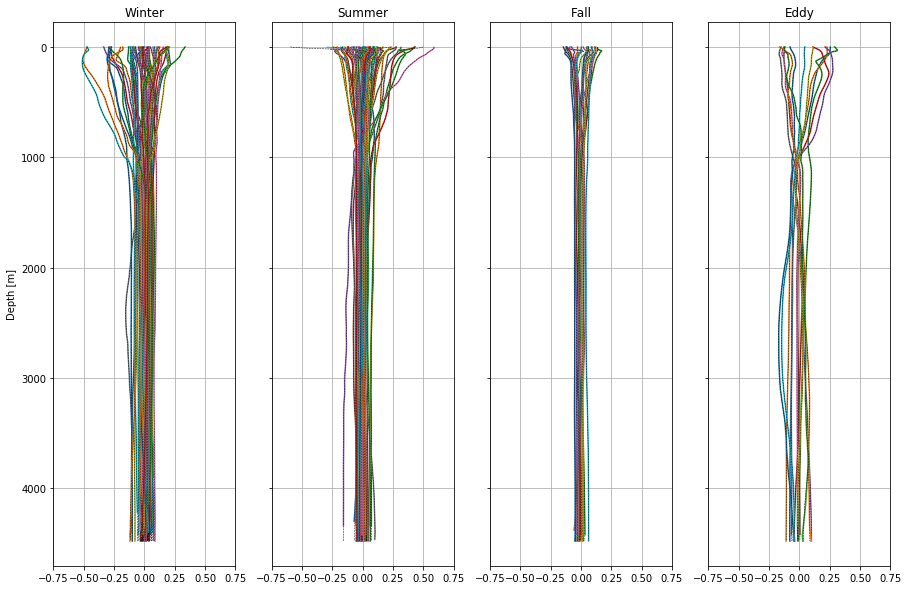

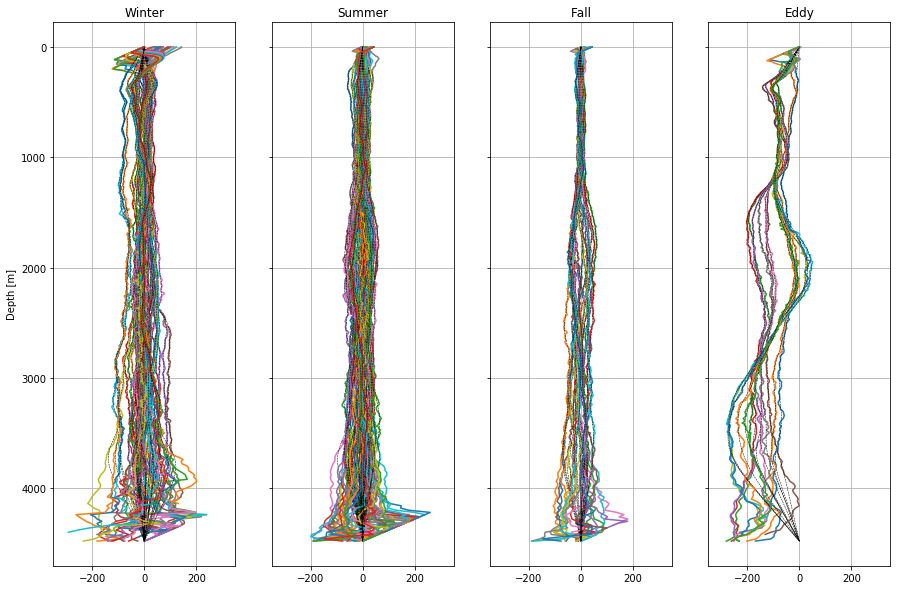

In [22]:
# --- Partition KE, PE by season (like bats) ---

# make backgrounds now just summer winter
# Summer = June 1 - Sept 15
d_sum = np.where(((Time_ordered > bd1)))[0]  # & (Time_ordered < bd2)
# Winter1 = (Feb 2 - June 1)
d_win1 = np.where((Time_ordered < bd1) & ((Info3 < 60) | (Info3 > 71)))[0]
# Winter2 = (Sept 15 - Nov 5)
d_win2 = np.where(Time_ordered > bd2)[0]
# Eddy
d_eddy = np.where((Info3 >= 60) & (Info3 <= 71))[0]
# combine
bckgrds = [d_win1, d_sum, d_win2, d_eddy]  # KEY!! 4, sets of profiles
bckgrds_key = 'Winter', 'Summer', 'Fall', 'Eddy'
k_h_win1 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
k_h_sum = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))
k_h_win2 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[2]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))
k_h_eddy = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[2]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))

# --- RATIO of KE_i / KE_total
KE_fraction_w1 = 100 * HKE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[0]],
                                                                         axis=0), (nmodes, 1))
PE_fraction_w1 = 100 * PE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[0]],
                                                                        axis=0), (nmodes, 1))
KE_fraction_s = 100 * HKE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[1]],
                                                                        axis=0), (nmodes, 1))
PE_fraction_s = 100 * PE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[1]],
                                                                       axis=0), (nmodes, 1))
KE_fraction_w2 = 100 * HKE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[2]],
                                                                         axis=0), (nmodes, 1))
PE_fraction_w2 = 100 * PE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[2]],
                                                                        axis=0), (nmodes, 1))
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes), np.nanmean(KE_fraction_w1, axis=1), yerr=np.nanstd(KE_fraction_w1, axis=1), label='Winter1', color=cols[0])
ax1.errorbar(np.arange(0, nmodes) + .1, np.nanmean(KE_fraction_s, axis=1), yerr=np.nanstd(KE_fraction_s, axis=1), label='Summer', color=cols[1])
ax1.errorbar(np.arange(0, nmodes) + .2, np.nanmean(KE_fraction_w2, axis=1), yerr=np.nanstd(KE_fraction_w2, axis=1), label='Winter2', color=cols[2])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_ylim([0, 90])
ax1.set_xlim([-.1, 8])
ax1.set_title('Fraction of KE in each Mode')
ax1.set_ylabel('Percent')
ax1.grid()
ax2.set_facecolor('#F5F5F5')
ax2.errorbar(np.arange(1, nmodes), np.nanmean(PE_fraction_w1[1:, :], axis=1), yerr=np.nanstd(PE_fraction_w1[1:, :], axis=1), color=cols[0])
ax2.errorbar(np.arange(1, nmodes) + .1, np.nanmean(PE_fraction_s[1:, :], axis=1), yerr=np.nanstd(PE_fraction_s[1:, :], axis=1), color=cols[1])
ax2.errorbar(np.arange(1, nmodes) + .2, np.nanmean(PE_fraction_w2[1:, :], axis=1), yerr=np.nanstd(PE_fraction_w2[1:, :], axis=1), color=cols[2])
ax2.set_ylim([0, 90])
ax2.set_title('Fraction of PE by Mode')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Mode Number')
plot_pro(ax2)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_energy_fracs.jpg", dpi=300)

# velocity profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = V_ordered[:, bckgrds[i]]
    vin_m = Vm_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-0.75, 0.75])
    ax[i].set_title(bckgrds_key[i])
ax[0].set_ylabel('Depth [m]')    
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].invert_yaxis()
plot_pro(ax[3])
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_v_seasonal.jpg", dpi=300)

# displacement profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = Eta_ordered[:, bckgrds[i]]
    vin_m = Etam_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-350, 350])
    ax[i].set_title(bckgrds_key[i])
ax[0].set_ylabel('Depth [m]')
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].invert_yaxis()
plot_pro(ax[3])
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_eta_seasonal.jpg", dpi=300)

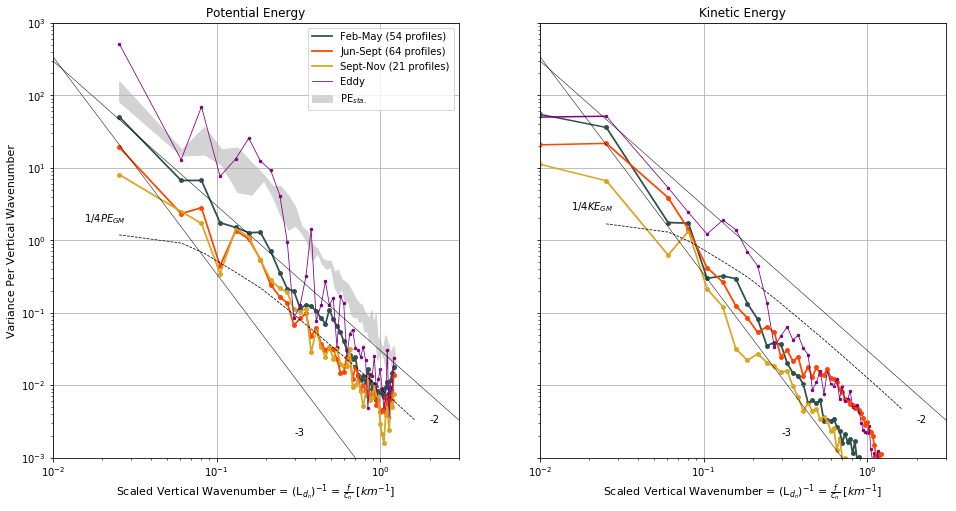

()

In [23]:
# --- PLOT ENERGY BY SEASON

matplotlib.rcParams['figure.figsize'] = (16,8)

f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
labs = 'Feb-May (' + str(np.shape(d_win1)[0]) + ' profiles)', 'Jun-Sept (' + str(np.shape(d_sum)[0]) + ' profiles)',\
        'Sept-Nov (' + str(np.shape(d_win2)[0]) + ' profiles)', 'Eddy'
ax1.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
                 label='PE$_{sta.}$', color='#D3D3D3')
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax2.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0:2] / dk, color=cols[i], linewidth=1.5)
    ax2.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk, color=cols[i], s=scz[i]*1.5, facecolors='none')
    seasonal_PE_output[1:, i] = np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[1:, i] = np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[0, i] = np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk
# -- GM
ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=11)
ax1.set_title('Potential Energy')
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax2.set_title('Kinetic Energy')
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)
# f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_energy_seasons.jpg", dpi=300)

In [309]:
sa = 1
if sa > 0:
    my_dict = {'depth': grid, 'KE': avg_KE, 'PE': avg_PE, 'c': c, 'f': f_ref, 'N2_all': N2_all, 'N2_per': N2,
               'PE_all': PE_per_mass_0, 'PE_per_prof_all': PE_per_mass_all, 'KE_all': HKE_per_mass_0,
               'background_eddy_indicies_for_energy': bckgrds, 'GMPE': GMPE, 'GMKE': GMKE,
               'epsilons_per_season': epsilons, 'season_key': bckgrds_info}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_energy_apr2019.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

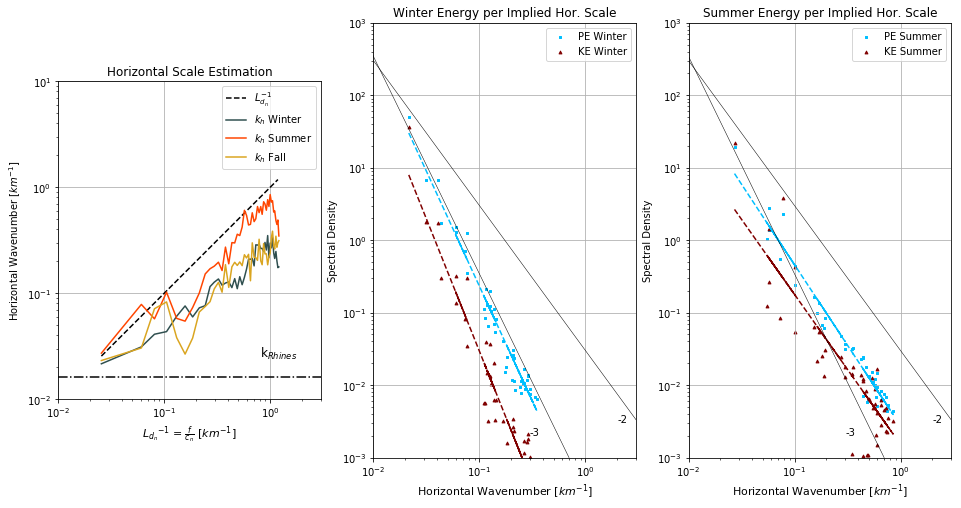

In [211]:
# Rhines Scale 
r_earth = 6371e3  # earth radius [m]
beta_ref = f_ref / (np.tan(np.deg2rad(ref_lat)) * r_earth)
K_beta_2 = 1 / np.sqrt(np.sqrt(np.nanmean(V2**2)) / beta_ref)

matplotlib.rcParams['figure.figsize'] = (16,8)
fig_special, (ax2, ax1, ax3) = plt.subplots(1, 3)

ax2.plot([1000 * f_ref / c[1], 1000 * f_ref / c[-2]], [1000 * f_ref / c[1], 1000 * f_ref / c[-2]], linestyle='--',
            color='k', linewidth=1.5, zorder=2, label=r'$L_{d_n}^{-1}$')
ax2.plot(sc_x, k_h_win1, color=cols[0], label=r'$k_h$ Winter', linewidth=1.5)
ax2.plot(sc_x, k_h_sum, color=cols[1], label=r'$k_h$ Summer', linewidth=1.5)
ax2.plot(sc_x, k_h_win2, color=cols[2], label=r'$k_h$ Fall', linewidth=1.5)
ax2.plot([10**-2, 10**1], 1e3 * np.array([K_beta_2, K_beta_2]), color='k', linestyle='-.')
ax2.text(0.8, 0.025, r'k$_{Rhines}$', fontsize=12)
ax2.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-2), 10 ** 1])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Horizontal Scale Estimation')
ax2.set_xlabel(r'$L_{d_n}$$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax2.set_ylabel(r'Horizontal Wavenumber [$km^{-1}$]')
ax2.set_aspect('equal')
ax2.grid()

# energy now as a function of horizontal wavenumber (slope fit too)
fit_max = 42
k_xx_w1 = k_h_win1.copy()
k_xx_s = k_h_sum.copy()
x_3h_w1 = np.log10(k_xx_w1[0:fit_max])
x_3h_s = np.log10(k_xx_s[0:fit_max])
# PE
yy_w1 = np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
yy_s = np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
y_3p_w1 = np.log10(yy_w1[0:fit_max])
y_3p_s = np.log10(yy_s[0:fit_max])
slope_pe_h_w1 = np.polyfit(x_3h_w1, y_3p_w1, 1)
y_g_pe_h_w1 = np.polyval(slope_pe_h_w1, x_3h_w1)
slope_pe_h_s = np.polyfit(x_3h_s, y_3p_s, 1)
y_g_pe_h_s = np.polyval(slope_pe_h_s, x_3h_s)
# KE
yy2_w1 = np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
yy2_s = np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
y_3h_w1 = np.log10(yy2_w1[0:fit_max])
y_3h_s = np.log10(yy2_s[0:fit_max])
slope_ke_h_w1 = np.polyfit(x_3h_w1, y_3h_w1, 1)
y_g_ke_h_w1 = np.polyval(slope_ke_h_w1, x_3h_w1)
slope_ke_h_s = np.polyfit(x_3h_s, y_3h_s, 1)
y_g_ke_h_s = np.polyval(slope_ke_h_s, x_3h_s)

scols = ['#00BFFF', '#6B8E23', '#800000']
# winter
# PE
ax1.scatter(k_h_win1, yy_w1, 8, color=scols[0], marker='s', label='PE Winter')
ax1.plot(10 ** x_3h_w1, 10 ** y_g_pe_h_w1, color=scols[0], linewidth=1.5, linestyle='--')
# KE
ax1.scatter(k_h_win1, yy2_w1, 8, color=scols[2], marker='^', label='KE Winter')
ax1.plot(10 ** x_3h_w1, 10 ** y_g_ke_h_w1, color=scols[2], linewidth=1.5, linestyle='--')
ax1.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
ax1.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
ax1.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
ax1.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
ax1.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
ax1.set_title('Winter Energy per Implied Hor. Scale')
ax1.set_ylabel('Spectral Density')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid()


# summer
ax3.scatter(k_h_sum, yy_s, 8, color=scols[0], marker='s', label='PE Summer')
ax3.plot(10 ** x_3h_s, 10 ** y_g_pe_h_s, color=scols[0], linewidth=1.5, linestyle='--')
ax3.scatter(k_h_sum, yy2_s, 8, color=scols[2], marker='^', label='KE Summer')
ax3.plot(10 ** x_3h_s, 10 ** y_g_ke_h_s, color=scols[2], linewidth=1.5, linestyle='--')
ax3.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
ax3.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
ax3.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
ax3.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
ax3.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
ax3.set_title('Summer Energy per Implied Hor. Scale')
ax3.set_ylabel('Spectral Density')
ax3.set_yscale('log')
ax3.set_xscale('log')
plot_pro(ax3)
# fig_special.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_energy_hor_sc.jpg", dpi=300)

In [102]:
# find velocity profiles with speeds in the upper few hundred meters (and eddy profiles)
# look at bottom t/s to see if there is stirring 
print(np.where(np.abs(V2[40, :]) > 0.25)[0])
strong_profs = Info2[np.where(np.abs(V2[40, :]) > 0.25)[0]]
print(strong_profs)

[ 14  15  46  47  49  50  51  52  67  87 102 122 126]
[  73.    73.5   80.5   81.    82.    82.5   83.    83.5  133.    63.5
   22.5  105.   107. ]


In [256]:
rho_1 = 27.5, 27.8, 27.98, 28.05, 28.1275, 28.13, 28.131
# rho_1 = 27.5, 27.8, 27.98, 28.05, 28.12, 28.125, 28.1275, 28.13, 28.11, 28.1275,

In [257]:
dg_raw_f = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg041_2018_raw_t_s_gamma.mat')
dg_data = dg_raw_f['out']
g_raw = dg_data['Neut_den'][0]
t_raw = dg_data['Temp'][0]
s_raw = dg_data['Sal'][0]
p_raw = dg_data['Pressure'][0]
time_raw = dg_data['Time'][0]
lon_raw = dg_data['Lon'][0]
lat_raw = dg_data['Lat'][0]
prof_n_36 = dg_data['prof_number'][0]
SA_grid = dg_data['SA_grid'][0][0]
CT_grid = dg_data['CT_grid'][0][0]
gamma_grid_4 = dg_data['Gamma4'][0][0]

spice_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
ct_per_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
sa_per_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
dep_rec_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
lon_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
lat_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
time_in_36 = np.nan * np.ones((len(prof_n_36), len(rho_1)))
for m in range(len(rho_1)):
    for i in range(0, len(prof_n_36)):
        this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
        sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
        ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
        z_on = np.interp(rho_1[m], np.squeeze(g_raw[i]), np.squeeze(this_z))
        
        dep_rec_36[i, m] = z_on
        sa_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(sa_r))
        ct_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(ct_r))
        lon_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lon_raw[i]))
        lat_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lat_raw[i]))
        time_in_36[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(time_raw[i]))
        spice_36[i, m] = gsw.spiciness1(sa_in, ct_in)
        ct_per_36[i, m] = ct_in
        sa_per_36[i, m] = sa_in
ref_lon_36 = np.nanmean(lon_in_36)        
ref_lat_36 = np.nanmean(lat_in_36) 

In [207]:
i

231

In [258]:
# raw T/S/Gamma/Spice from 35 
dg_raw_f = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2015_raw_t_s_gamma.mat')
dg_data = dg_raw_f['out']
g_raw = dg_data['Neut_den'][0]
t_raw = dg_data['Temp'][0]
s_raw = dg_data['Sal'][0]
p_raw = dg_data['Pressure'][0]
time_raw = dg_data['Time'][0]
lon_raw = dg_data['Lon'][0]
lat_raw = dg_data['Lat'][0]
prof_n = dg_data['prof_number'][0]
SA_grid = dg_data['SA_grid'][0][0]
CT_grid = dg_data['CT_grid'][0][0]
gamma_grid_4 = dg_data['Gamma4'][0][0]

spice = np.nan * np.ones((len(prof_n), len(rho_1)))
ct_per = np.nan * np.ones((len(prof_n), len(rho_1)))
sa_per = np.nan * np.ones((len(prof_n), len(rho_1)))
dep_rec = np.nan * np.ones((len(prof_n), len(rho_1)))
lon_in = np.nan * np.ones((len(prof_n), len(rho_1)))
lat_in = np.nan * np.ones((len(prof_n), len(rho_1)))
time_in = np.nan * np.ones((len(prof_n), len(rho_1)))
for m in range(len(rho_1)):
    for i in range(20, len(prof_n)):
        this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
        sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
        ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
        z_on = np.interp(rho_1[m], np.squeeze(g_raw[i]), np.squeeze(this_z))
        
        dep_rec[i, m] = z_on
        sa_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(sa_r))
        ct_in = np.interp(z_on, np.squeeze(this_z), np.squeeze(ct_r))
        lon_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lon_raw[i]))
        lat_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(lat_raw[i]))
        time_in[i, m] = np.interp(z_on, np.squeeze(this_z), np.squeeze(time_raw[i]))
        spice[i, m] = gsw.spiciness1(sa_in, ct_in)
        ct_per[i, m] = ct_in
        sa_per[i, m] = sa_in
ref_lon = np.nanmean(lon_in)        
ref_lat = np.nanmean(lat_in) 
np.nanstd(spice[:, 5])

0.0013509495949315597

In [183]:
prof_n[20]

array([[30]], dtype=uint8)

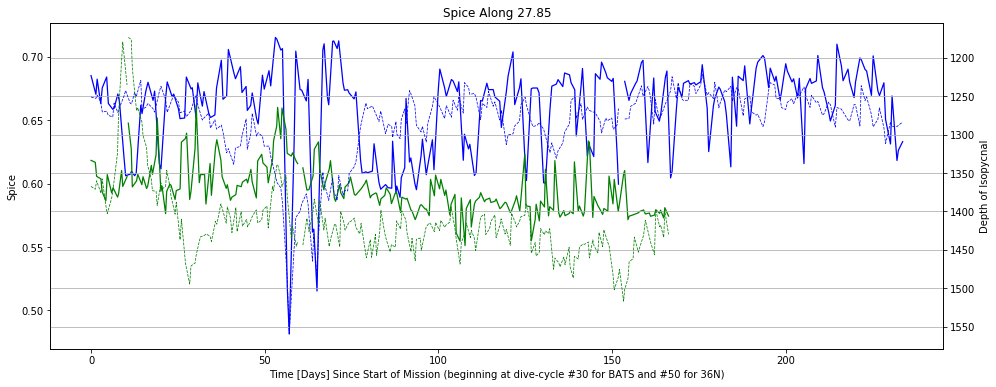

In [189]:
# time series of spice on an isopycnal
thisi_i = [5]
f, ax = plt.subplots()
ax2 = ax.twinx()
for thisi in thisi_i:
    t_grid = np.arange(0, 150, 1)
    t_lags = np.arange(1, 30, 1)
    # bats 
    this_t = time_in[:, thisi] - time_in[20, thisi]
    this_ct = ct_per[:, thisi]
    this_sp = spice[:, thisi]
    this_dep = dep_rec[:, thisi]
    ct_grid = np.interp(t_grid, this_t, this_ct)
    sp_grid = np.interp(t_grid, this_t, this_sp)
    dep_grid = np.interp(t_grid, this_t, this_dep)

    # 36n
    this_t_36 = time_in_36[:, thisi] - time_in_36[0, thisi]
    this_ct_36 = ct_per_36[:, thisi]
    this_sp_36 = spice_36[:, thisi]
    this_dep_36 = dep_rec_36[:, thisi]
    ct_grid_36 = np.interp(t_grid, this_t_36, this_ct_36)
    sp_grid_36 = np.interp(t_grid, this_t_36, this_sp_36)
    dep_grid_36 = np.interp(t_grid, this_t_36, this_dep_36)

    ax.plot(this_t, this_sp, label='BATS 2015', color='b', linewidth=1.25)
    # ax.plot(t_grid, sp_grid, color='r', linestyle='--')
    ax2.plot(this_t, this_dep, color='b', linewidth=0.75, linestyle='--')
    ax.plot(this_t_36, this_sp_36, 'g', label='36N 2018', linewidth=1.25)
    # ax.plot(t_grid, sp_grid_36, color='y', linestyle='--')
    ax2.plot(this_t_36, this_dep_36, color='g', linewidth=0.75, linestyle='--')
    ax.set_title('Spice Along ' + str(rho_1[thisi]))
    ax.set_ylabel('Spice')
    ax.set_xlabel('Time [Days] Since Start of Mission (beginning at dive-cycle #30 for BATS and #50 for 36N)')
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, fontsize=11)
    # ax.set_ylim([0.14, 0.171])
    # ax2.set_ylim([3100, 4000])
    # ax.set_ylim([0.5, 0.75])
    # ax2.set_ylim([1100, 1600])
    # ax.set_ylim([np.nanmax(this_sp)+.05, np.nanmax(this_sp)+.05])
    # ax2.set_ylim([900, 1400])
ax2.set_ylabel('Depth of Isopycnal')
ax2.invert_yaxis()
plot_pro(ax2)

# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_36n_spice_comp_4.jpg", dpi=300)

# acf = np.nan*np.ones(len(t_lags))
# for m in range(len(t_lags)):
#     ct_i = np.nan * np.ones(len(ct_grid) - t_lags[m])
#     for i in range(len(ct_grid) - t_lags[m]):
#         ct_i[i] = (ct_grid[i] - np.nanmean(ct_grid)) * (ct_grid[i+t_lags[m]] - np.nanmean(ct_grid))
#     acf[m] = (1/(len(ct_grid) - t_lags[m])) * np.nansum(ct_i)   

# f, ax = plt.subplots()
# ax.plot(t_lags, acf/(np.nanstd(ct_grid)**2))
# plot_pro(ax)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in less
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: Mean of empty slice


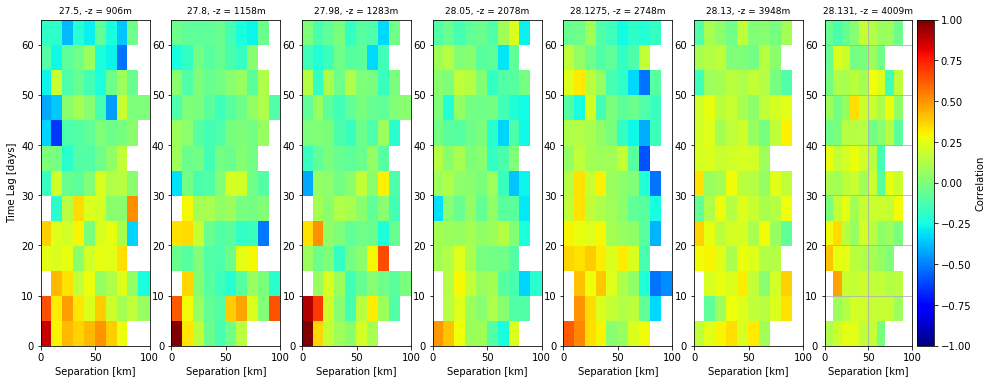

In [209]:
# ---  T/S variability (and correlations) on isopycnals --- 
# ---------------------------
# Mode Amplitude Correlations 
matplotlib.rcParams['figure.figsize'] = (16,6)    
dist_t_win = np.arange(0, 105, 10)
t_t_win = np.arange(0, 70, 5)
avg_cor = np.nan * np.ones((len(t_t_win), len(rho_1)))
f, ax = plt.subplots(1, len(rho_1))
this_ref_lon = ref_lon
this_ref_lat = ref_lat
for l in range(len(rho_1)):
    this_lon_in = lon_in
    this_lat_in = lat_in
    this_time_in = time_in
    this_spice = spice
    
    x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (this_lon_in[:, l] - this_ref_lon) / 1000
    y = 1852 * 60 * (this_lat_in[:, l] - this_ref_lat) / 1000
    
    n = len(this_spice[:, l]) - np.sum(np.isnan(this_spice[:, l]))
    sp_mean = np.nanmean(this_spice[:, l])
    sp_var = np.nanvar(this_spice[:, l])
    t_range = np.nanmax(this_time_in[:, l]) - np.nanmin(this_time_in[:, l])
    t = this_time_in[:, l]
#     time_tile = np.tile(t, (len(t), 1))
#     dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
#     time_lag = np.abs(time_tile - time_tile.T)

    # distances apart
    for i in range(len(x) - 1):
        if i < 1:
            dist_x = x[i+1:] - x[i]
            dist_y = y[i+1:] - y[i]
            dist_t = np.sqrt(dist_x**2 + dist_y**2)
            time_l = np.abs(t[i] - t[i+1:])
            # pairs of spice values that correspond to list of time lags and spatial separation 
            spice_count = np.array((this_spice[i, l] * np.ones(len(x[i+1:])), this_spice[i+1:, l]))
            # each observation is used in many pairs 
        else:
            dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
            dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
            dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i+1:] - y[i])**2)))
            time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
            spice_count = np.concatenate((spice_count, 
                                          np.array((this_spice[i, l] * np.ones(len(x[i + 1:])), this_spice[i + 1:, l]))), axis=1)
        
    # define each box as all points that fall within a time and space lag
    corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))

    # spatial separation             
    for dd in range(len(dist_t_win) - 1):
        for tt in range(len(t_t_win) - 1):
            in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                                (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
            if len(in_box) > 25:
                # pairs that fall in each box 
                inski_with = spice_count[:, in_box]                   
                inski, inski_i = np.unique(spice_count[:, in_box], return_index=True)
                i_mean = np.nanmean(inski)
                n = len(inski_with[0, :]) # number of pairs
                variance = np.nanvar(inski)
                covi = (inski_with[0, :] - i_mean) * (inski_with[1, :] - i_mean)
                corr_i_all[tt, dd] = (1 / ((n) * variance)) * np.nansum(covi)   
                # (n - t_t_win[tt]/.8)
                
    avg_cor[:, l] = np.nanmean(corr_i_all[:, 2:15], axis=1)
    corr_i_all[np.isnan(corr_i_all)] = -999
    cmap = plt.cm.jet
    pa = ax[l].pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap=cmap)
    cmap.set_under('w')
    ax[l].set_xlabel('Separation [km]')
    ax[l].set_title(str(rho_1[l]) + ', -z = ' + str(np.int(np.nanmean(dep_rec[:, l]))) + 'm', fontsize=9)
plt.colorbar(pa, label='Correlation')
ax[0].set_ylabel('Time Lag [days]')
plot_pro(ax[l])  
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_bats_spice_corr.jpg", dpi=300)

1.3478198848810038e-05

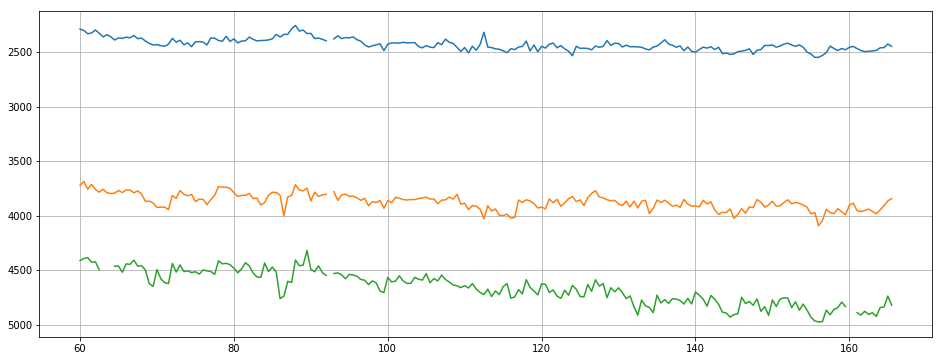

()

In [117]:
f, ax = plt.subplots()
# ax.plot(np.arange(20, 20 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 0])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 3])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 5])
ax.plot(np.arange(50, 50 + len(prof_n_36)/2, 0.5), dep_rec_36[:, 6])
ax.invert_yaxis()
plot_pro(ax)

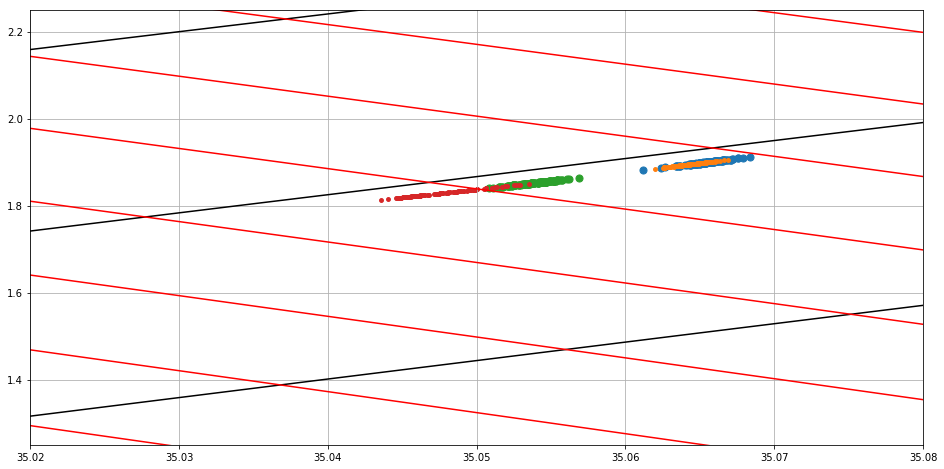

()

In [261]:
SP_grid = gsw.spiciness2(SA_grid, CT_grid)
f, ax = plt.subplots()
gg = ax.contour(SA_grid, CT_grid, gamma_grid_4, colors='k', levels=np.arange(27, 28.5, 0.05))
ax.clabel(gg, inline_spacing=-3, fmt='%1.0f', colors='k')
spg = ax.contour(SA_grid, CT_grid, SP_grid, colors='r', levels=np.arange(0, 1, 0.025))
ax.clabel(spg)

ini = 4
ax.scatter(sa_per[0:150, ini], ct_per[0:150, ini], s=50)
ax.scatter(sa_per[150:, ini], ct_per[150:, ini], s=15)
ax.scatter(sa_per_36[0:115, ini], ct_per_36[0:115, ini], s=50)
ax.scatter(sa_per_36[115:, ini], ct_per_36[115:, ini], s=15)
ax.set_xlim([35.02, 35.08])
ax.set_ylim([1.25, 2.25])
plot_pro(ax)

In [254]:
ct_per[0:150, ini]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        2.74991042,  2.74028151,  2.75048162,  2.7286037 ,  2.71292768,
        2.70036157,  2.69927261,  2.71399419,  2.71343197,  2.70521678,
        2.72060226,  2.72230446,  2.71871632,  2.71406469,  2.71877249,
        2.70603421,  2.71231942,  2.71501499,  2.73613547,  2.73118263,
        2.72670954,  2.70952745,  2.70639373,  2.70359053,  2.71754954,
        2.7166591 ,  2.71921045,  2.72068495,  2.73418535,  2.7209978 ,
        2.71496682,  2.71065907,  2.71398487,  2.71265889,  2.71978253,
        2.70915197,  2.72997954,  2.73229706,  2.71718066,  2.70933732,
        2.73217787,  2.73577423,  2.73175954,  2.72773269,  2.71997822,
        2.70454657,  2.72206901,  2.72871622,  2.70911898,  2.72

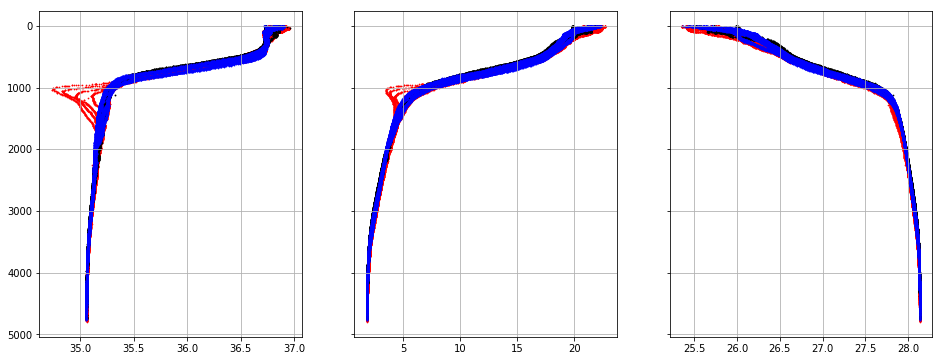

()

In [140]:
# bats 2015
e_pre = np.where((prof_n >= 45) & (prof_n <= 55))[0]
e_in = np.where((prof_n > 57) & (prof_n < 70))[0]
e_po = np.where((prof_n >= 70) & (prof_n <= 80))[0]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
for i in e_in:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.5, color='r')
        ax2.scatter(ct_r, this_z, s=0.5, color='r')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='r')
#     ax1.scatter(s_raw[i], this_z, s=0.5)
#     ax2.scatter(t_raw[i], this_z, s=0.5)
for i in e_pre:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.75, color='k')
        ax2.scatter(ct_r, this_z, s=0.75, color='k')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='k')
#     ax1.scatter(s_raw[i], this_z, s=0.75, color='k')
#     ax2.scatter(t_raw[i], this_z, s=0.75, color='k')  
for i in e_po:
    this_z = -1.0 * gsw.z_from_p(p_raw[i], np.nanmean(lat_raw[i]))
    sa_r = gsw.SA_from_SP(s_raw[i], p_raw[i], lon_raw[i], lat_raw[i])
    ct_r = gsw.CT_from_t(s_raw[i], t_raw[i], p_raw[i])
    
    if np.nanmax(this_z) > 4400:
        ax1.scatter(sa_r, this_z, s=0.75, color='b')
        ax2.scatter(ct_r, this_z, s=0.75, color='b')
        ax3.scatter(g_raw[i], this_z, s=0.5, color='b')
#     ax1.scatter(s_raw[i], this_z, s=0.75, color='k')
#     ax2.scatter(t_raw[i], this_z, s=0.75, color='k')   
    
# ax1.set_ylim([4200, 4820])   
# ax1.set_xlim([35.04, 35.075])
# ax2.set_xlim([1.75, 2])
ax1.invert_yaxis()
ax1.grid()
ax2.grid()
plot_pro(ax3)

### prof_n

In [ ]:
# take sample transect and compute potential vorticity 
this_transect = 25  # 35 = eddy 
dace_mw_i = DACe_MW[this_transect][0:-1]
dacn_mw_i = DACn_MW[this_transect][0:-1]
dg_v_i = v_g[this_transect][:, 0:-1]
dg_v_e_i = v_g_east[this_transect][:, 0:-1]
dg_v_n_i = v_g_north[this_transect][:, 0:-1]
avg_sig0_per_dep_i = avg_sig0_per_dep_0[this_transect]
avg_ct_per_dep_i = avg_ct_per_dep_0[this_transect]
avg_sa_per_dep_i = avg_sa_per_dep_0[this_transect]
dg_v_lon_i = mwe_lon[this_transect][0:-1]
dg_v_lat_i = mwe_lat[this_transect][0:-1]
dg_v_dive_no_i = profile_tags_per[this_transect][0:-1]

# extract individual profiles of this transect 
p_in_0 = np.where((profile_tags >= dg_v_dive_no_i.min()) & (profile_tags <= dg_v_dive_no_i.max()))[0]
p_in = np.append(p_in_0, p_in_0[-1] + 1)
lon_p_i = lon[:, p_in]
lat_p_i = lat[:, p_in]

ref_lat_i = np.nanmean(lat_p_i[0, 0])
ref_lon_i = np.nanmean(lon_p_i[0, 0])
tsx = 1852 * 60 * np.cos(np.deg2rad(ref_lat_i)) * (lon_p_i - ref_lon_i)
tsy = 1852 * 60 * (lat_p_i - ref_lat_i)
tsd = np.sqrt(tsx**2 + tsy**2)
grid_i = np.transpose(np.tile(grid, (len(p_in), 1)))

vsx = 1852 * 60 * np.cos(np.deg2rad(ref_lat_i)) * (dg_v_lon_i - ref_lon_i)
vsy = 1852 * 60 * (dg_v_lat_i - ref_lat_i)
vsd = np.sqrt(vsx**2 + vsy**2)

b_i = g * (1 - (1000 + avg_sig0_per_dep_i)/1027)  

dv_dz_i = np.nan * np.ones(np.shape(dg_v_i))
for i in range(len(vsx)):
    dv_dz_i[:, i] = np.gradient(dg_v_i[:, i], -1 * grid)
dv_dx_i = np.nan * np.ones(np.shape(dg_v_i))
db_dx_i = np.nan * np.ones(np.shape(dg_v_i))
for i in range(len(grid)):
    dv_dx_i[i, 1:-1] = np.gradient(dg_v_i[i, 1:-1], vsd[1:-1])
    db_dx_i[i, 1:-1] = np.gradient(b_i[i, 1:-1], vsd[1:-1])

q_i = (dv_dx_i + f_ref) * np.transpose(np.tile(N2[:, 0], (len(vsd), 1))) - (db_dx_i * dv_dz_i)
# q_i[q_i < -1*10**(25)] = np.nan
# q_i[q_i > 1*10**(25)] = np.nan
q_i = q_i / (10**(-10))

matplotlib.rcParams['figure.figsize'] = (12,8)
f, ax = plt.subplots()
ax.contourf(vsd, grid, q_i, levels=np.arange(0, 100, 0.5))  # q_i, vmin = 0, vmax = 1)
ax.contour(vsd, grid, q_i, levels=np.arange(0, 50, 5), colors='w')  # q_i, vmin = 0, vmax = 1)
# ax.contour(vsd, grid, q_i, levels=np.arange(0, 20, 4), colors='g')  # q_i, vmin = 0, vmax = 1)
ax.contour(vsd, grid, dg_v_i, levels=np.arange(-.3, .3, 0.025), colors='r')  # q_i, vmin = 0, vmax = 1)
ax.scatter(tsd, grid_i, s=1)
ax.set_ylim([0, 2000])
ax.invert_yaxis()
plot_pro(ax)